## Instability of Parameter Estimates

Any estimate comes with a degree of uncertainty, but often that uncertainty is ignored. This is incredibly dangerous in finance, as a wrong estimate can be the difference between steady gains and massive losses. Time to touch on how estimates are often taken, and some ways to quantify the uncertainty.

### Instability of estimates

Whenever we consider a set of observations, our calculation of a parameter can only be an estimate. It will change as we take more measurements or as time passes and we get new observations. We can quantify the uncertainty in our estimate by looking at how the parameter changes as we look at different subsets of the data. In financial applications, data often comes in time series. In this case, we can estimate a parameter at different points in time; say, for the previous 30 days. By looking at how much this moving estimate fluctuates as we change our time window, we can compute the instability of the estimated parameter.


In [2]:
import yfinance as yf
import requests
import datetime
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats as stats
from pandas_datareader import data as pdr
from matplotlib import style
from math import pi

yf.pdr_override()

## The Sharpe Ratio

One statistic often used to describe the performance of assets and portfolios is the Sharpe ratio, which measures the additional return per unit additional risk achieved by a portfolio, relative to a risk-free source of return such as Treasury bills. As with mean and standard deviation, we can compute a rolling Sharpe ratio to see how our estimate changes through time.

In [8]:
def sharpe_ratio(asset, riskfree):
    return np.mean(asset - riskfree)/np.std(asset - riskfree)

start_date = '2012-01-01'
end_date = '2015-01-01'

treasury_ret = pdr.get_data_yahoo('BIL', start=start_date, end=end_date, interval = "1d")['Adj Close'].pct_change()[1:]
pricing = pdr.get_data_yahoo('AMZN', start=start_date, end=end_date, interval = "1d")['Adj Close']
returns = pricing.pct_change()[1:] # Get the returns on the asset



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


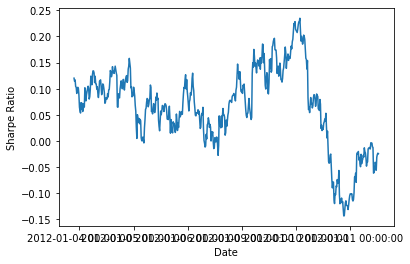

In [46]:
# Compute the running Sharpe ratio
running_sharpe = [sharpe_ratio(returns[i-90:i], treasury_ret[i-90:i]) for i in range(90, len(returns))]

# Plot running Sharpe ratio up to 100 days before the end of the data set
_, ax1 = plt.subplots()
ax1.plot(range(90, len(returns)-100), running_sharpe[:-100]);
ticks = ax1.get_xticks()


ax1.set_xticklabels(pricing.index)

plt.xlabel('Date')
plt.ylabel('Sharpe Ratio');

Mean of running Sharpe ratio: 0.06406517811830954
std of running Sharpe ratio: 0.07774924523885414


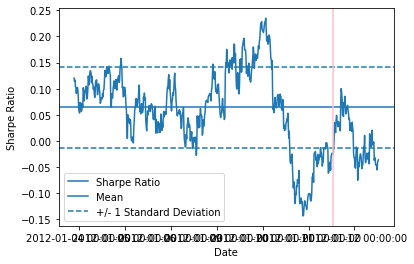

In [48]:
# Compute the mean and std of the running Sharpe ratios up to 100 days before the end
mean_rs = np.mean(running_sharpe[:-100])
std_rs = np.std(running_sharpe[:-100])

# Plot running Sharpe ratio
_, ax2 = plt.subplots()
ax2.set_xticklabels(pricing.index) # Label x-axis with dates
ax2.plot(range(90, len(returns)), running_sharpe)

# Plot its mean and the +/- 1 standard deviation lines
ax2.axhline(mean_rs)
ax2.axhline(mean_rs + std_rs, linestyle='--')
ax2.axhline(mean_rs - std_rs, linestyle='--')

# Indicate where we computed the mean and standard deviations
# Everything after this is 'out of sample' which we are comparing with the estimated mean and std
ax2.axvline(len(returns) - 100, color='pink');
plt.xlabel('Date')
plt.ylabel('Sharpe Ratio')
plt.legend(['Sharpe Ratio', 'Mean', '+/- 1 Standard Deviation'])

print('Mean of running Sharpe ratio:', mean_rs)
print('std of running Sharpe ratio:', std_rs)

The standard deviation in this case is about a quarter of the range, so this data is extremely volatile. Taking this into account when looking ahead gave a better prediction than just using the mean, although we still observed data more than one standard deviation away. We could also compute the rolling mean of the Sharpe ratio to try and follow trends; but in that case, too, we should keep in mind the standard deviation.

### Example: Moving Average

Let's say you take the average with a lookback window; how would you determine the standard error on that estimate? Let's start with an example showing a 90-day moving average.

[*********************100%***********************]  1 of 1 completed


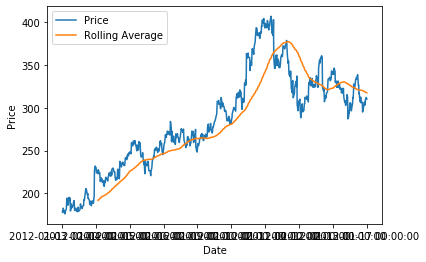

In [53]:
# Load time series of prices
start_date = '2012-01-01'
end_date = '2015-01-01'

pricing = pdr.get_data_yahoo('AMZN', start=start_date, end=end_date, interval = "1d")['Adj Close']


# Compute the rolling mean for each day
mu = pricing.rolling(90).mean()

# Plot pricing data
_, ax1 = plt.subplots()
ax1.plot(pricing) 
ticks = ax1.get_xticks()
ax1.set_xticklabels(pricing.index) # Label x-axis with dates
plt.ylabel('Price')
plt.xlabel('Date')

# Plot rolling mean
ax1.plot(mu);
plt.legend(['Price','Rolling Average']);

This lets us see the instability/standard error of the mean, and helps anticipate future variability in the data. We can quantify this variability by computing the mean and standard deviation of the rolling mean.

In [52]:
print('Mean of rolling mean:', np.mean(mu))
print('Std of rolling mean:', np.std(mu))

Mean of rolling mean: 288.3863395523925
Std of rolling mean: 51.1351502493079


In fact, the standard deviation, which we use to quantify variability, is itself variable. Below we plot the rolling standard deviation (for a 90-day window), and compute its mean and standard deviation.

Mean of rolling std: 17.40382772370537
std of rolling std: 7.544692082480285


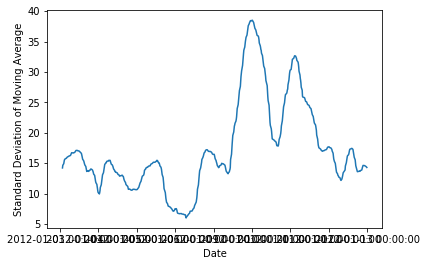

In [55]:
# Compute rolling standard deviation
std = pricing.rolling(90).std()

# Plot rolling std
_, ax2 = plt.subplots()
ax2.plot(std)
ax2.set_xticklabels(pricing.index) # Label x-axis with dates
plt.ylabel('Standard Deviation of Moving Average')
plt.xlabel('Date')

print('Mean of rolling std:', np.mean(std))
print('std of rolling std:', np.std(std))

To see what this changing standard deviation means for our data set, let's plot the data again along with the Bollinger bands: the rolling mean, one rolling standard deviation (of the data) above the mean, and one standard deviation below.

Note that although standard deviations give us more information about the spread of the data, we cannot assign precise probabilities to our expectations for future observations without assuming a particular distribution for the underlying process.

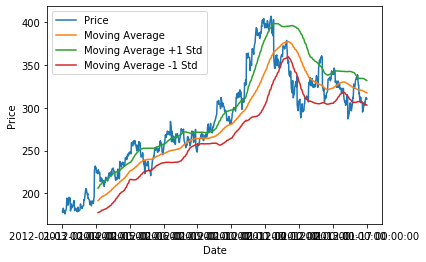

In [56]:
# Plot original data
_, ax3 = plt.subplots()
ax3.plot(pricing)
ax3.set_xticklabels(pricing.index) # Label x-axis with dates

# Plot Bollinger bands
ax3.plot(mu)
ax3.plot(mu + std)
ax3.plot(mu - std);
plt.ylabel('Price')
plt.xlabel('Date')
plt.legend(['Price', 'Moving Average', 'Moving Average +1 Std', 'Moving Average -1 Std'])

## Closing

Whenever we compute a parameter for a data set, we should also compute its volatility. Otherwise, we do not know whether or not we should expect new data points to be aligned with this parameter. A good way of computing volatility is dividing the data into subsets and estimating the parameter from each one, then finding the variability among the results. There may still be outside factors which are introduced after our sample period and which we cannot predict. However, the instability analysis and testing for standard error is still very useful for telling us how much we should distrust our estimates.